In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

Using TensorFlow backend.


In [2]:
def my_DNN_classifier(in_layer,optimizer='adadelta',neurons=32,dropout=0.4,activation='relu',activation_final='sigmoid',shape='two'):
    K.clear_session()
    model=None
    model = Sequential()
    model.add(Dense(neurons, input_dim=in_layer, kernel_initializer='normal',activation=activation))
    model.add(Dropout(dropout))
    if(shape=='none'):
        None
    if(shape=='one'):
        model.add(Dense(neurons, kernel_initializer='normal',activation=activation))
        model.add(Dropout(dropout))
    if(shape=='two'):
        model.add(Dense(neurons, kernel_initializer='normal',activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(neurons, kernel_initializer='normal',activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal', activation=activation_final))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optimizer)
    return model

In [3]:
LR_X_Pipe = [('AddPoly',PolynomialFeatures()),('LR',LogisticRegression())]
LR_X = Pipeline(LR_X_Pipe)

# Data Type 1

In [4]:
data=pd.read_csv('data_train_1.csv',index_col='PassengerId').drop(['Missing_Embark','Missing_Deck'],axis=1)
X=data.drop('Survived',axis=1).as_matrix()
Y=data['Survived'].as_matrix()
test=pd.read_csv('data_test_1.csv',index_col='PassengerId').drop(['Missing_Embark','Missing_Deck'],axis=1)

clf_LR = LogisticRegression()
LR_X.set_params(AddPoly__degree=2, LR__C=0.1)
clf_LRX = LR_X
clf_ABC=AdaBoostClassifier()
clf_GBC=GradientBoostingClassifier(loss='exponential',n_estimators=150,criterion='mse')
clf_RFC=RandomForestClassifier(max_features=None,n_estimators=30)
clf_KNN=KNeighborsClassifier(p=1,n_neighbors=21)
clf_SVM=svm.SVC(C=1000,degree=4,kernel='poly')
#clf_MLP=MLPClassifier(hidden_layer_sizes=(32,)*4,alpha=0.1,max_iter=1000)
clf_DNN=KerasClassifier(build_fn=my_DNN_classifier,batch_size=1024,in_layer=X.shape[1],epochs=1000,verbose=0)

list_names=['LR',
            'LR_X',
            'ABC',
            'GBC',
            'RFC',
            'KNN',
            'SVM',
            'DNN']#,'MLP'
list_clf=[clf_LR,
          clf_LRX,
          clf_ABC,
          clf_GBC,
          clf_RFC,
          clf_KNN,
          clf_SVM,
          clf_DNN]#,clf_MLP
list_names_clf=list(zip(list_names,list_clf))

for clf, label in zip(list_clf,list_names):
    scores = cross_val_score(clf, X, Y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.80 (+/- 0.03) [LR]
Accuracy: 0.83 (+/- 0.03) [LR_X]
Accuracy: 0.81 (+/- 0.03) [ABC]
Accuracy: 0.83 (+/- 0.03) [GBC]
Accuracy: 0.81 (+/- 0.04) [RFC]
Accuracy: 0.82 (+/- 0.03) [KNN]
Accuracy: 0.84 (+/- 0.03) [SVM]
Accuracy: 0.83 (+/- 0.04) [DNN]


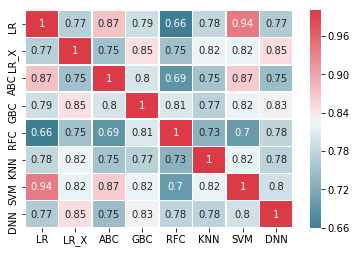

In [12]:
test_predictions=pd.DataFrame(columns=list_names,index=test.index)
for name,clf in list_names_clf:
    clf.fit(X,Y)
    test_predictions[name]=clf.predict(test)    
sns.heatmap(test_predictions.corr(),annot=True, linewidths=.5,cmap=sns.diverging_palette(220, 10, as_cmap = True))

In [31]:
test_predictions[['LR', 'LR_X', 'ABC', 'GBC','GBC', 'RFC', 'KNN', 'SVM', 'DNN']].sum(axis=1)/9

PassengerId
892     0.000000
893     0.111111
894     0.000000
895     0.000000
896     1.000000
897     0.000000
898     0.555556
899     0.000000
900     1.000000
901     0.000000
902     0.000000
903     0.111111
904     1.000000
905     0.000000
906     1.000000
907     1.000000
908     0.000000
909     0.000000
910     0.333333
911     0.333333
912     0.000000
913     0.555556
914     1.000000
915     0.000000
916     1.000000
917     0.000000
918     1.000000
919     0.111111
920     0.333333
921     0.000000
          ...   
1280    0.000000
1281    0.000000
1282    0.222222
1283    1.000000
1284    0.888889
1285    0.000000
1286    0.000000
1287    1.000000
1288    0.000000
1289    1.000000
1290    0.000000
1291    0.000000
1292    1.000000
1293    0.000000
1294    1.000000
1295    0.111111
1296    0.222222
1297    0.555556
1298    0.000000
1299    0.000000
1300    1.000000
1301    0.888889
1302    1.000000
1303    1.000000
1304    0.555556
1305    0.000000
1306    1.000000
13

## Voting Hard

In [6]:
clf_voting_hard=VotingClassifier(estimators=list_names_clf,voting='hard')
scoreVH=cross_val_score(clf_voting_hard, X, Y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scoreVH.mean(), scoreVH.std(), 'Voting Hard'))
clf_voting_hard.fit(X,Y)
predictions=clf_voting_hard.predict(test)
pd.DataFrame(predictions,columns=['Survived'],index=test.index).to_csv('./predictions_VotingHard_data_1.csv')

ValueError: could not broadcast input array from shape (90,1) into shape (90)

In [55]:
# Manual voting, the above is not working and I don't know why
test_predictions['Vote']=np.round(test_predictions[['LR', 'LR_X', 'ABC', 'GBC','GBC', 'RFC', 'KNN', 'SVM', 'DNN']].sum(axis=1)/9).astype(int)
tempdf=pd.DataFrame(columns=['Survived'],index=test.index)
tempdf['Survived']=test_predictions['Vote']
tempdf.to_csv('./predictions_VotingHard_data_1.csv')

## Voting Soft

In [7]:
list_names_prob=[x for x in list_names if x not in ['SVM']]
list_clf_prob=[x for x in list_clf if x not in [clf_SVM]]
list_names_clf_prob=list(zip(list_names_prob,list_clf_prob))


clf_voting_soft=VotingClassifier(estimators=list_names_clf_prob,voting='soft')
scoreVS=cross_val_score(clf_voting_soft, X, Y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scoreVS.mean(), scoreVS.std(), 'Voting Soft'))
clf_voting_soft.fit(X,Y)
predictions=clf_voting_soft.predict(test)
pd.DataFrame(predictions,columns=['Survived'],index=test.index).to_csv('./predictions_VotingSoft_data_1.csv')

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

Accuracy: 0.83 (+/- 0.04) [Voting Soft]


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Data Type 2

In [40]:
data=pd.read_csv('data_train_2.csv',index_col='PassengerId').drop(['Missing_Embark','Missing_Deck'],axis=1)
X=data.drop('Survived',axis=1).as_matrix()
Y=data['Survived'].as_matrix()
test=pd.read_csv('data_test_2.csv',index_col='PassengerId').drop(['Missing_Embark','Missing_Deck'],axis=1)

clf_LR = LogisticRegression(penalty='l1',solver='saga')
LR_X.set_params(AddPoly__degree=3, LR__C=0.1,LR__solver='lbfgs')
clf_LRX = LR_X
clf_ABC=AdaBoostClassifier(n_estimators=20)
clf_GBC=GradientBoostingClassifier(n_estimators=140,criterion='mse',subsample=0.6)
clf_RFC=RandomForestClassifier(max_features=None,n_estimators=30)
clf_KNN=KNeighborsClassifier(p=1,n_neighbors=13)
clf_SVM=svm.SVC(C=10,degree=4,kernel='poly')
#clf_MLP=MLPClassifier(hidden_layer_sizes=(40,)*4,alpha=0.01,max_iter=1000)
clf_DNN=KerasClassifier(build_fn=my_DNN_classifier,batch_size=1024,in_layer=X.shape[1],epochs=1000,verbose=0)

list_names=['LR',
            'LR_X',
            'ABC',
            'GBC',
            'RFC',
            'KNN',
            'SVM',
            'DNN']
list_clf=[clf_LR,
          clf_LRX,
          clf_ABC,
          clf_GBC,
          clf_RFC,
          clf_KNN,
          clf_SVM,
          clf_DNN]
list_names_clf=list(zip(list_names,list_clf))

for clf, label in zip(list_clf,list_names):
    scores = cross_val_score(clf, X, Y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.83 (+/- 0.03) [LR]
Accuracy: 0.83 (+/- 0.04) [LR_X]
Accuracy: 0.83 (+/- 0.03) [ABC]
Accuracy: 0.84 (+/- 0.04) [GBC]
Accuracy: 0.83 (+/- 0.04) [RFC]
Accuracy: 0.83 (+/- 0.03) [KNN]
Accuracy: 0.83 (+/- 0.03) [SVM]
Accuracy: 0.82 (+/- 0.04) [DNN]


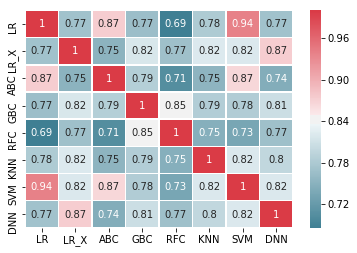

In [41]:
test_predictions=pd.DataFrame(columns=list_names,index=test.index)
for name,clf in list_names_clf:
    clf.fit(X,Y)
    test_predictions[name]=clf.predict(test)    
sns.heatmap(test_predictions.corr(),annot=True, linewidths=.5,cmap=sns.diverging_palette(220, 10, as_cmap = True))

## Voting Hard

In [10]:
clf_voting_hard=VotingClassifier(estimators=list_names_clf,voting='hard')
scoreVH=cross_val_score(clf_voting_hard, X, Y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scoreVH.mean(), scoreVH.std(), 'Voting Hard'))
clf_voting_hard.fit(X,Y)
predictions=clf_voting_hard.predict(test)
pd.DataFrame(predictions,columns=['Survived'],index=test.index).to_csv('./predictions_VotingHard_data_2.csv')

ValueError: could not broadcast input array from shape (90,1) into shape (90)

In [54]:
# Manual voting, the above is not working and I don't know why
test_predictions['Vote']=np.round(test_predictions[['LR', 'LR_X', 'ABC', 'GBC','GBC', 'RFC', 'KNN', 'SVM', 'DNN']].sum(axis=1)/9).astype(int)
tempdf=pd.DataFrame(columns=['Survived'],index=test.index)
tempdf['Survived']=test_predictions['Vote']
tempdf.to_csv('./predictions_VotingHard_data_2.csv')

## Voting Soft

In [11]:
list_names_prob=[x for x in list_names if x not in ['SVM']]
list_clf_prob=[x for x in list_clf if x not in [clf_SVM]]
list_names_clf_prob=list(zip(list_names_prob,list_clf_prob))

clf_voting_soft=VotingClassifier(estimators=list_names_clf_prob,voting='soft')
scoreVS=cross_val_score(clf_voting_soft, X, Y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scoreVS.mean(), scoreVS.std(), 'Voting Soft'))
clf_voting_soft.fit(X,Y)
predictions=clf_voting_soft.predict(test)
pd.DataFrame(predictions,columns=['Survived'],index=test.index).to_csv('./predictions_VotingSoft_data_2.csv')

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

Accuracy: 0.84 (+/- 0.05) [Voting Soft]


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
